In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
algorithms = ['OBNC', 'OBNC-remove-sensitive', 
              'OBNC-optimize-demographic-parity-0', #'OBNC-optimize-demographic-parity-0.5',
              'OBNC-fair-0'] #, 'OBNC-fair-0.5']

alg_names = {
    'OBNC': 'OBNC',
    'OBNC-remove-sensitive': 'Fair-OBNC-rs',
    'OBNC-optimize-demographic-parity-0': 'Fair-OBNC-dp',
    'OBNC-optimize-demographic-parity-0.5': 'Fair-OBNC-dp (prob = 0.5)',
    'OBNC-fair-0': 'Fair-OBNC',
    'OBNC-fair-0.5': 'Fair-OBNC (prob = 0.5)'
}

attr = {
    'ads': 'local',
    'bank': 'housing',
    'biodeg': 'V25',
    'churn': 'voice_mail_plan',
    'credit': 'A1',
    'monks1': 'attr3',
    'phishing': 'having_IP_Address',
    'sick': 'referral_source_other',
    'vote': 'immigration'
}

attr_fairness = {
    'adult': ['sex_Male', 'race_White'],
    'german': ['sex_Male'],
    'compas': ['sex', 'race_Caucasian'],
    'ricci': ['Race_W'],
    'diabetes': ['race_Caucasian'],
    'titanic': ['sex']
}

noise_types = ['random', 'flip', 'bias', 'balanced_bias']
type_names = {'random': 'Random', 
            'flip': 'Label Flipping', 
            'bias': 'Asymmetrical Bias',
            'balanced_bias': 'Symmetrical Bias'}

colors = {'OBNC':'tab:purple',
          'OBNC-remove-sensitive': 'tab:pink',
          'OBNC-optimize-demographic-parity-0': 'tab:cyan',
          'OBNC-optimize-demographic-parity-0.5': 'darkcyan',
          'OBNC-fair-0': 'tab:gray',
          'OBNC-fair-0.5': 'dimgrey'}

markers = {
    0: 'o',
    0.1: 's',
    0.2: 'v',
    0.3: 'D',
    0.4: 'P',
    0.5: 'p'
}

pred_metrics = ['accuracy_0.5', 'roc_auc']

fair_metrics = [
        'equal_opportunity_difference_0.5', 
        'predictive_equality_difference_0.5',
        'demographic_parity_difference_0.5',
        'equalized_odds_difference_0.5']

metric_names = {
    'accuracy_0.5': 'Accuracy',
    'roc_auc': 'AUC',
    'equal_opportunity_difference_0.5': 'Equal Opportunity dif.',
    'predictive_equality_difference_0.5': 'Predictive Equality dif.',
    'demographic_parity_difference_0.5': 'Demographic Parity dif.',
    'equalized_odds_difference_0.5': 'Equalized Odds dif.'
}

metrics = pred_metrics + fair_metrics

nr = [i/10 for i in range(1, 6)]

In [3]:
runs = {}
for noise_type in noise_types:
    runs[noise_type] = {}
    for dataset in attr.keys():
        exp = f'{dataset}_{attr[dataset]}'
        for alg in algorithms:
            runs[noise_type][f'{exp}_{alg}'] = pd.read_csv(f'../noiseinjection_results/{noise_type}/{exp}_{alg}.csv').fillna(0)
runs['fairness'] = {}
for dataset in attr_fairness.keys():
    for sensitive_attr in attr_fairness[dataset]:
        exp = f'{dataset}_{sensitive_attr}'
        for alg in algorithms:
            runs['fairness'][f'{exp}_{alg}'] = pd.read_csv(f'../fairness_benchmark_results/{exp}_{alg}.csv').fillna(0)

In [4]:
if not os.path.exists('thesis_report/fair-OBNC/fairness_benchmarks'):
    os.makedirs('thesis_report/fair-OBNC/fairness_benchmarks')

if not os.path.exists('thesis_report/fair-OBNC/noise_injection'):
    os.makedirs('thesis_report/fair-OBNC/noise_injection')

# Noise injection experiments

## Similarity to original labels

In [5]:
def similarity(algorithms):
    fig = plt.figure(figsize=(12, 4))
    axs = fig.subplots(1, 2, sharex=True)

    for i in range(2):
        ax = axs[i]
        
        for alg in algorithms:
            values = []
            for noise_rate in nr:
                avg_value = []
                for dataset in attr.keys():
                    exp = f'{dataset}_{attr[dataset]}'
                    run = runs[noise_types[i+2]][f'{exp}_{alg}']
                    avg_value.append(run.loc[run['params.noise_rate'] == noise_rate][f'metrics.correction_acc'].mean())
                values.append(np.mean(avg_value))
            
            ax.plot(nr, values, label=alg_names[alg], color=colors[alg])
        
        ax.set_xlabel('Noise rate', fontsize=12)         
        if i == 0:
            ax.set_ylabel('Reconstruction Score, $r$', fontsize=12)
        ax.set_title(f'Noise type: {type_names[noise_types[i+2]]}', fontsize=14)

    ax.legend()
    plt.subplots_adjust(wspace=0.13, hspace=0.15)
    plt.savefig('thesis_report/fair-OBNC/noise_injection/similarity.png', bbox_inches='tight')
    plt.show()

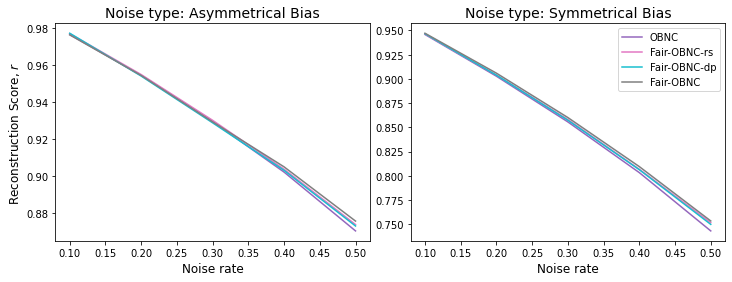

In [6]:
similarity(['OBNC', 'OBNC-remove-sensitive','OBNC-optimize-demographic-parity-0', 'OBNC-fair-0'])

In [7]:
def similarity_datasets(noise_type, algorithms):
    fig = plt.figure(figsize=(20, 12))
    axs = fig.subplots(3, 3, sharex=True)

    for i in range(9):
        row = i // 3
        col = i % 3
        ax = axs[row, col]
        dataset = list(attr.keys())[i]  
        
        for alg in algorithms:
            values = []
            for noise_rate in nr:
                exp = f'{dataset}_{attr[dataset]}'
                run = runs[noise_type][f'{exp}_{alg}']
                values.append(run.loc[run['params.noise_rate'] == noise_rate][f'metrics.correction_acc'].mean())
            
            ax.plot(nr, values, label=alg_names[alg], color=colors[alg])
        
        if row == 2:
            ax.set_xlabel('Noise rate', fontsize=12)         
        if col == 0:
            ax.set_ylabel('Reconstruction Score, $r$', fontsize=12)
        ax.set_title(f'Dataset: {dataset}', fontsize=12)

    ax.legend()
    plt.subplots_adjust(wspace=0.11, hspace=0.14)
    plt.suptitle(f'Noise type: {type_names[noise_type]}', fontsize=16, y=0.93)
    plt.savefig(f'thesis_report/fair-OBNC/noise_injection/similarity_datasets_{noise_type}.png', bbox_inches='tight')
    plt.show()

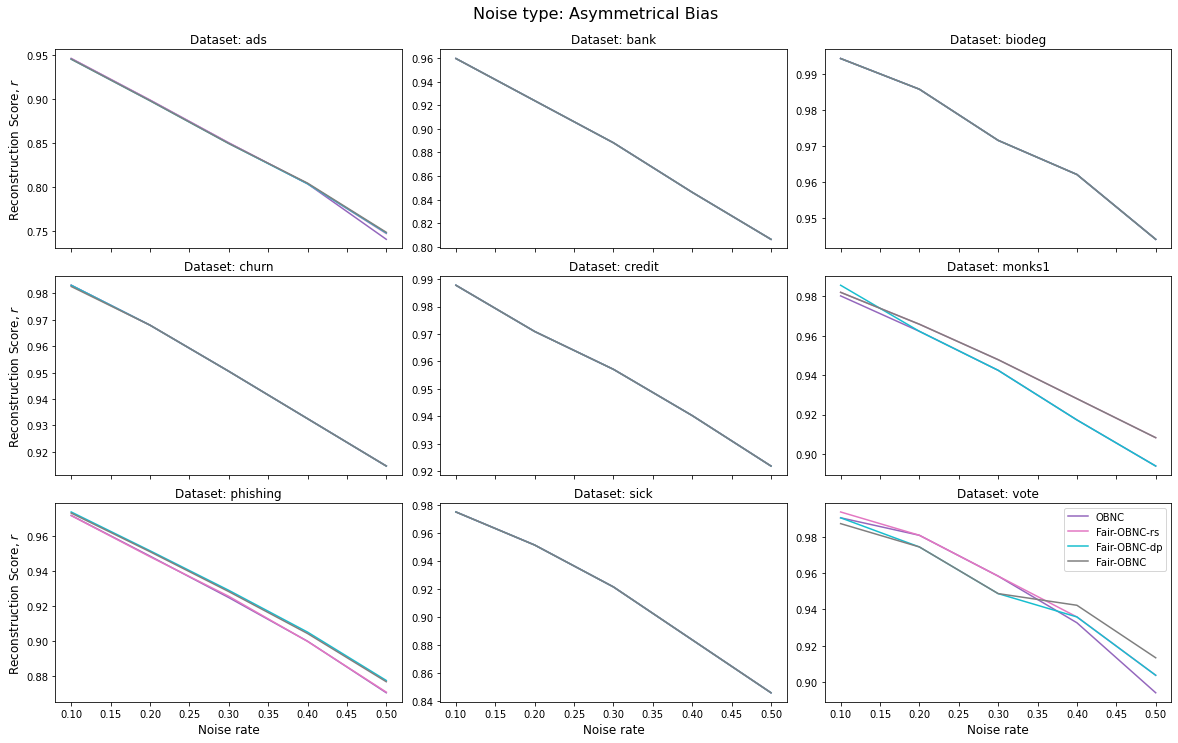

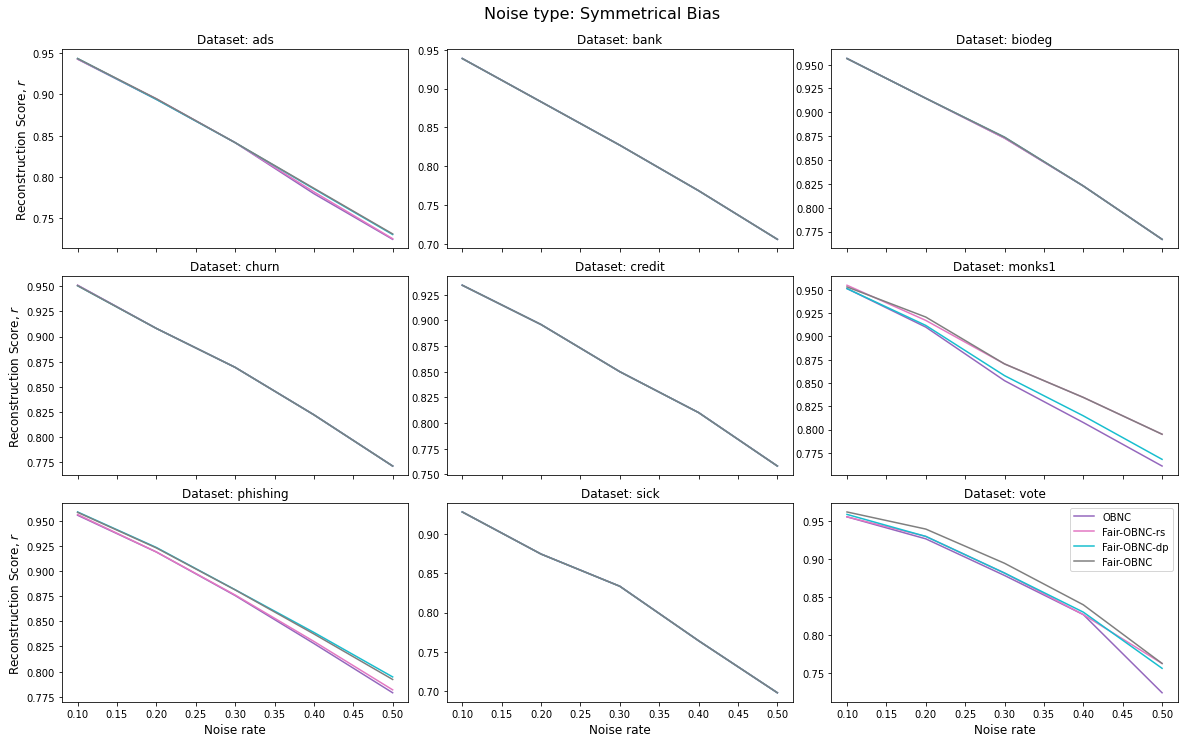

In [8]:
for noise_type in ['bias', 'balanced_bias']:
    similarity_datasets(noise_type, ['OBNC', 'OBNC-remove-sensitive','OBNC-optimize-demographic-parity-0', 'OBNC-fair-0'])

## Noisy test set

In [9]:
def trade_off_curve(alg, noise_type, test_set, fair_metric, nr, ax, datasets, noisy=False, labels=False):
    predictive_performance = []
    fairness = []

    if test_set == 'original':
        pred_original = []
        fair_original = []

    for dataset in datasets:
        exp = f'{dataset}_{attr[dataset]}'
        run = runs[noise_type][f'{exp}_{alg}']
        run = run.loc[(run['tags.test_set'] == test_set) & (run['params.noise_rate'].isin(nr))]

        if noisy:
            train_set = 'noisy'
        else:
            train_set = 'corrected'

        predictive_performance.append(run.loc[(run['tags.train_set'] == train_set)].sort_values(by='params.noise_rate', ascending=True)['metrics.roc_auc'].values)
        fairness.append(run.loc[(run['tags.train_set'] == train_set)].sort_values(by='params.noise_rate', ascending=True)[f'metrics.{fair_metric}'].values)
        
        if test_set == 'original':
            pred_original.append(run.loc[(run['tags.train_set'] == 'original') & (run['params.noise_rate'] == 0.1)]['metrics.roc_auc'].values[0])
            fair_original.append(run.loc[(run['tags.train_set'] == 'original') & (run['params.noise_rate'] == 0.1)][f'metrics.{fair_metric}'].values[0])
        
    if test_set == 'original':
        predictive_performance = [np.mean(pred_original)] + list(np.mean(np.array(predictive_performance), axis=0))
        fairness = [np.mean(fair_original)] + list(np.mean(np.array(fairness), axis=0))
    else:
        predictive_performance = list(np.mean(np.array(predictive_performance), axis=0))
        fairness = list(np.mean(np.array(fairness), axis=0))
    
    if test_set == 'original':
        nr = [0.0] + nr

    if noisy:
        ax.plot(fairness, predictive_performance, color='red', linestyle='--', linewidth=1)
        for i in range(len(nr)):
            ax.scatter(fairness[i], predictive_performance[i], color='red', marker=markers[nr[i]], label=f'Noise rate = {nr[i]}', s=20)
    else:
        if labels:
            ax.plot(fairness, predictive_performance, color=colors[alg], label=alg_names[alg], linewidth=1)
        else:
            ax.plot(fairness, predictive_performance, color=colors[alg])
        for i in range(len(nr)):
            ax.scatter(fairness[i], predictive_performance[i], color=colors[alg], marker=markers[nr[i]], s=20)

In [10]:
def trade_off_separate_algs(noise_type, test_set, fair_metric, nr):
    fig = plt.figure(figsize=(12, 8))
    axs = fig.subplots(2, 2, sharey=True, sharex=True)

    for i in range(4):
        alg = algorithms[i]
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        trade_off_curve(alg, noise_type, test_set, fair_metric, nr, ax, attr.keys())
        trade_off_curve('OBNC', noise_type, test_set, fair_metric, nr, ax, attr.keys(), noisy=True)
        
        if row == 1:
            ax.set_xlabel(metric_names[fair_metric], fontsize=12) 
        if col == 0:
            ax.set_ylabel('AUC', fontsize=12)
        ax.set_title(alg_names[alg], fontsize=12)

    axs[0, 0].legend()
    plt.suptitle(f'Noise type: {type_names[noise_type]}', fontsize=16, y=0.93)
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    plt.savefig(f'thesis_report/fair-OBNC/noise_injection/{test_set}_test_{fair_metric}_{noise_type}.png', bbox_inches='tight')
    plt.show()

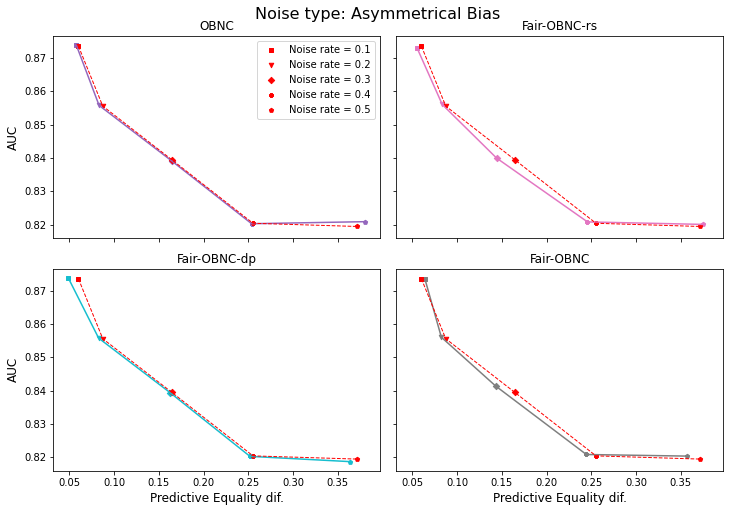

In [11]:
for metric in fair_metrics:
    trade_off_separate_algs('bias', 'noisy', metric, nr)

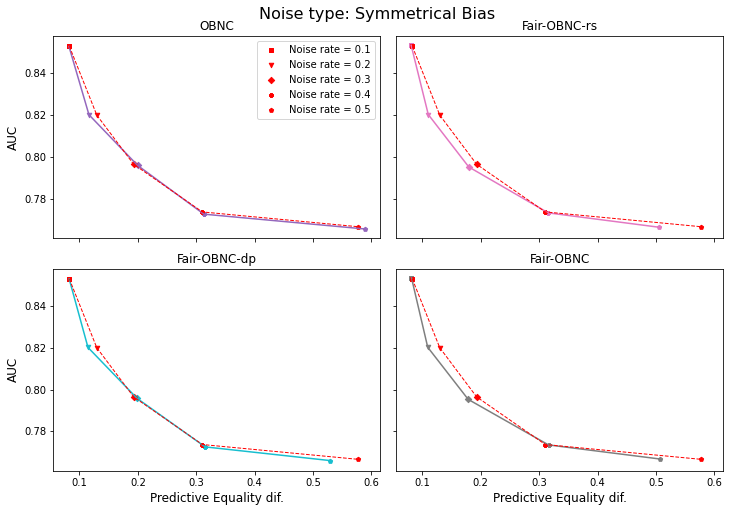

In [12]:
for metric in fair_metrics:
    trade_off_separate_algs('balanced_bias', 'noisy', metric, nr)

In [13]:
def trade_off_curve_all_algs(test_set, fair_metric, algorithms):
    fig = plt.figure(figsize=(15, 5))
    axs = fig.subplots(1, 2)
    for i in range(2):
        noise_type = noise_types[i+2]
        ax = axs[i]
        trade_off_curve('OBNC', noise_type, test_set, fair_metric, nr, ax, attr.keys(), noisy=True)
        for alg in algorithms:
            trade_off_curve(alg, noise_type, test_set, fair_metric, nr, ax, attr.keys(), labels=True)
        
        ax.set_xlabel(metric_names[fair_metric], fontsize=12) 
        if i == 0:
            ax.set_ylabel('AUC', fontsize=12)
        ax.set_title(f'Noise type: {type_names[noise_type]}', fontsize=14)
    axs[1].legend()
    plt.subplots_adjust(wspace=0.1, hspace=0.15)
    plt.savefig(f'thesis_report/fair-OBNC/noise_injection/{test_set}_test_{fair_metric}.png', bbox_inches='tight')
    plt.show()

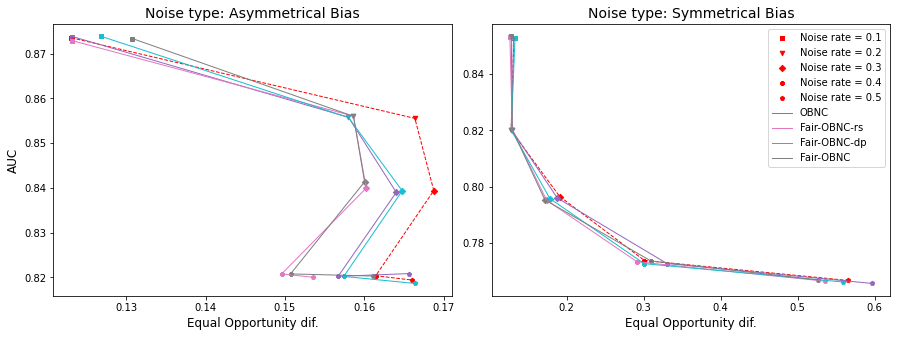

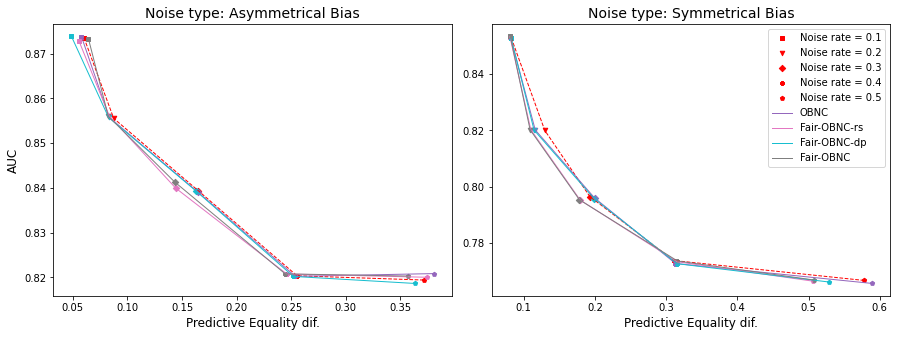

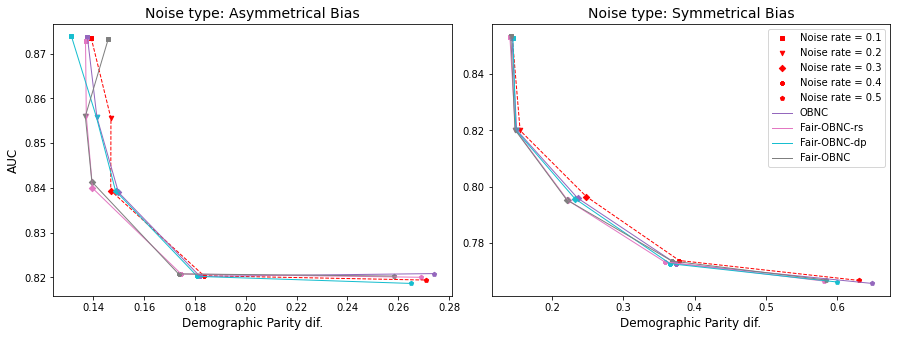

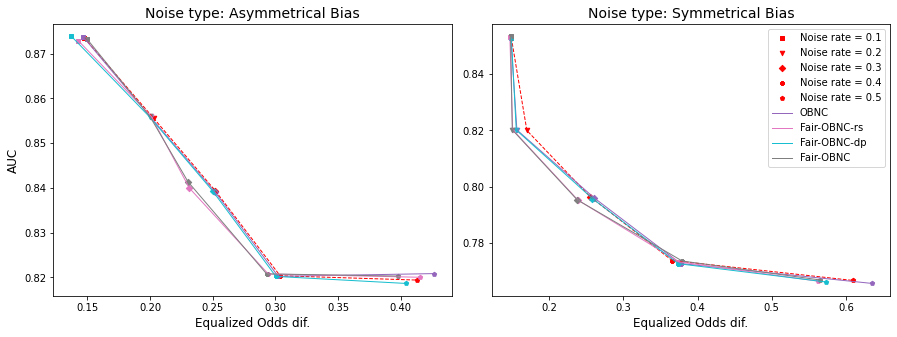

In [14]:
for metric in fair_metrics:
    trade_off_curve_all_algs('noisy', metric, 
                         ['OBNC', 'OBNC-remove-sensitive','OBNC-optimize-demographic-parity-0', 'OBNC-fair-0'])

In [50]:
def trade_off_curve_all_algs_dataset(test_set, fair_metric, algorithms, dataset):
    fig = plt.figure(figsize=(15, 5))
    axs = fig.subplots(1, 2)
    for i in range(2):
        noise_type = noise_types[i+2]
        ax = axs[i]
        trade_off_curve('OBNC', noise_type, test_set, fair_metric, nr, ax, [dataset], noisy=True)
        for alg in algorithms:
            trade_off_curve(alg, noise_type, test_set, fair_metric, nr, ax, [dataset], labels=True)
        
        ax.set_xlabel(metric_names[fair_metric], fontsize=12) 
        if i == 0:
            ax.set_ylabel('AUC', fontsize=12)
        ax.set_title(f'Noise type: {type_names[noise_type]}', fontsize=14)
    axs[1].legend()
    plt.subplots_adjust(wspace=0.1, hspace=0.15)
    plt.suptitle(f'Dataset: {dataset}', fontsize=16, y=1)
    plt.savefig(f'thesis_report/fair-OBNC/noise_injection/{test_set}_test_{fair_metric}_{dataset}.png', bbox_inches='tight')
    plt.show()

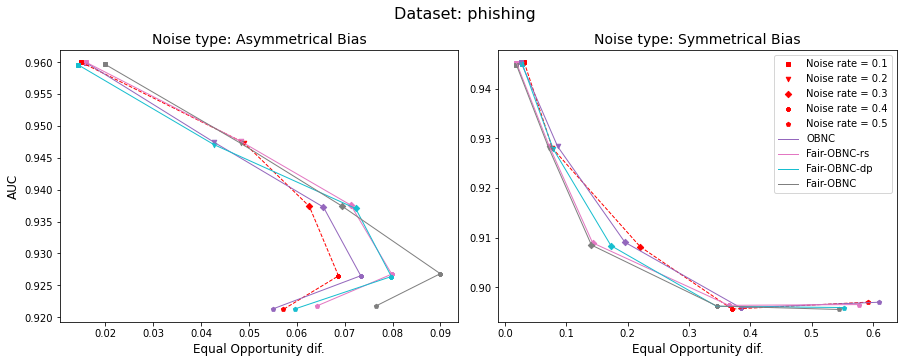

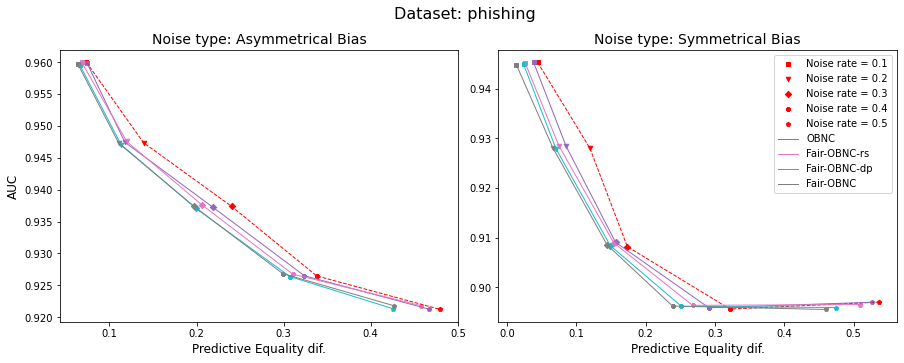

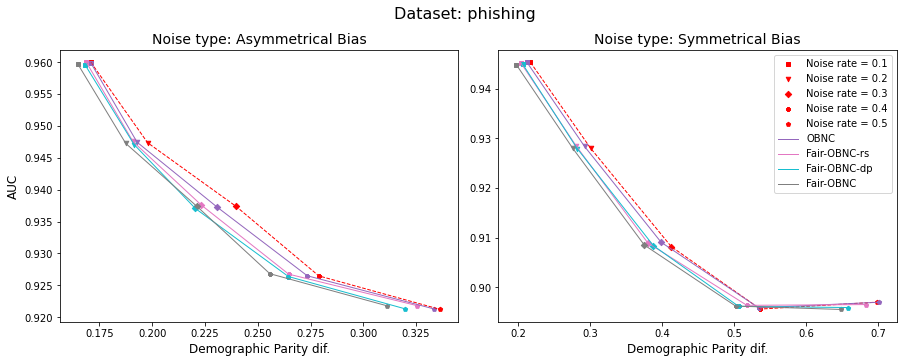

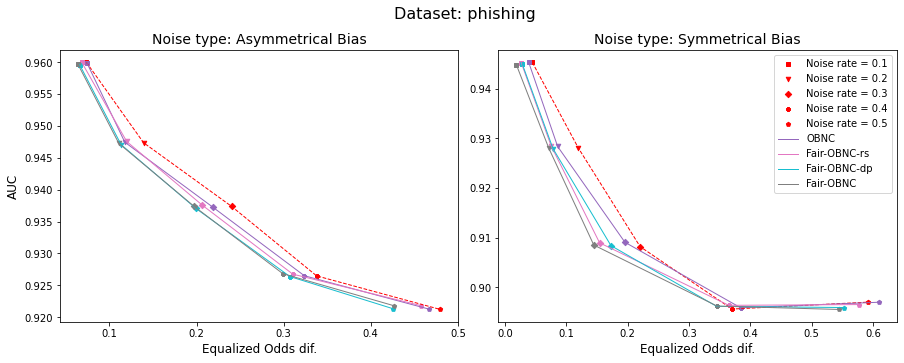

In [51]:
for metric in fair_metrics:
    trade_off_curve_all_algs_dataset('noisy', metric, 
                         ['OBNC', 'OBNC-remove-sensitive','OBNC-optimize-demographic-parity-0', 'OBNC-fair-0'], 'phishing')

In [17]:
# test_set = 'noisy'
# fair_metric = 'predictive_equality_difference_0.5'

# fig = plt.figure(figsize=(15, 5))
# axs = fig.subplots(1, 2)
# for i in range(2):
#     noise_type = noise_types[i+2]
#     ax = axs[i]
#     trade_off_curve('OBNC', noise_type, test_set, fair_metric, nr, ax, noisy=True)
#     for alg in ['OBNC-optimize-demographic-parity-0', 'OBNC-optimize-demographic-parity-0.5']:
#         trade_off_curve(alg, noise_type, test_set, fair_metric, nr, ax, labels=True)
    
#     ax.set_xlabel(metric_names[fair_metric], fontsize=12) 
#     if i == 0:
#         ax.set_ylabel('AUC', fontsize=12)
#     ax.set_title(f'Noise type: {type_names[noise_type]}' , fontsize=14)
# axs[1].legend()
# plt.subplots_adjust(wspace=0.1, hspace=0.15)
# plt.savefig(f'thesis_report/fair-OBNC/noise_injection/{test_set}_test_{fair_metric}_dp.png', bbox_inches='tight')
# plt.show()

In [18]:
# test_set = 'noisy'
# fair_metric = 'predictive_equality_difference_0.5'

# fig = plt.figure(figsize=(15, 5))
# axs = fig.subplots(1, 2)
# for i in range(2):
#     noise_type = noise_types[i+2]
#     ax = axs[i]
#     trade_off_curve('OBNC', noise_type, test_set, fair_metric, nr, ax, noisy=True)
#     for alg in ['OBNC-fair-0', 'OBNC-fair-0.5']:
#         trade_off_curve(alg, noise_type, test_set, fair_metric, nr, ax, labels=True)
    
#     ax.set_xlabel(metric_names[fair_metric], fontsize=12) 
#     if i == 0:
#         ax.set_ylabel('AUC', fontsize=12)
#     ax.set_title(f'Noise type: {type_names[noise_type]}', fontsize=14)
# axs[1].legend()
# plt.subplots_adjust(wspace=0.1, hspace=0.15)
# plt.savefig(f'thesis_report/fair-OBNC/noise_injection/{test_set}_test_{fair_metric}_both.png', bbox_inches='tight')
# plt.show()

In [19]:
def trade_off_all_algs(test_set, fair_metric, algorithms, noise_rate):
    fig = plt.figure(figsize=(12, 4))
    axs = fig.subplots(1, 2)

    for i in range(2):
        noise_type = noise_types[i+2]
        for alg in algorithms:
            fairness = []
            predictive_performance = []
            for dataset in attr.keys():
                run = runs[noise_type][f'{dataset}_{attr[dataset]}_{alg}']
                run = run.loc[(run['tags.test_set'] == test_set) & (run['tags.train_set'] == 'corrected') & (run['params.noise_rate'] == noise_rate)]
                fairness.append(run[f'metrics.{fair_metric}'].values[0])
                predictive_performance.append(run['metrics.roc_auc'].values[0])
            axs[i].scatter(np.mean(fairness), np.mean(predictive_performance), color=colors[alg], label=alg_names[alg])

        fairness = []
        predictive_performance = []
        for dataset in attr.keys():
            run = runs[noise_type][f'{dataset}_{attr[dataset]}_{alg}']
            run = run.loc[(run['tags.test_set'] == test_set) & (run['tags.train_set'] == 'noisy') & (run['params.noise_rate'] == noise_rate)]
            fairness.append(run[f'metrics.{fair_metric}'].values[0])
            predictive_performance.append(run['metrics.roc_auc'].values[0])
        axs[i].scatter(np.mean(fairness), np.mean(predictive_performance), color='red', marker='x', label='noisy')
    
        axs[i].set_title(f'Noise type: {type_names[noise_type]}', fontsize=14)
        axs[i].set_xlabel(metric_names[fair_metric], fontsize=12)
        if i == 0:
            axs[i].set_ylabel('AUC', fontsize=12)
    lgd = axs[1].legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.savefig(f'thesis_report/fair-OBNC/noise_injection/{test_set}_test_{fair_metric}_{noise_rate}.png', bbox_inches='tight', bbox_extra_artists=(lgd,))
    plt.show()

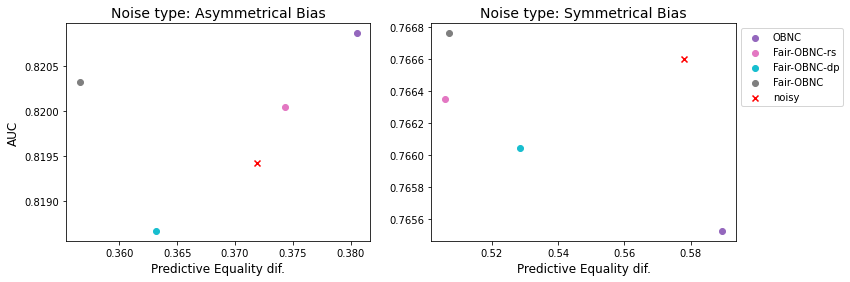

In [20]:
trade_off_all_algs('noisy', 'predictive_equality_difference_0.5', 
                   algorithms, 0.5)

In [21]:
def metric_separate_datasets(noise_type, metric, test_set):
    fig = plt.figure(figsize=(20, 12))
    axs = fig.subplots(3, 3, sharex=True)

    for i in range(9):
        row = i // 3
        col = i % 3
        ax = axs[row, col]
        dataset = list(attr.keys())[i]

        for alg in algorithms:
            exp = f'{dataset}_{attr[dataset]}'
            run = runs[noise_type][f'{exp}_{alg}']
            run = run.loc[(run['tags.test_set'] == test_set) & (run['tags.train_set'] == 'corrected')]
            ax.plot(nr, run.loc[run['params.noise_rate'].isin(nr)].sort_values('params.noise_rate', ascending=True)[f'metrics.{metric}'], label=alg, color=colors[alg])

        if row == 2:
            ax.set_xlabel('Noise rate')
        if col == 0:
            ax.set_ylabel(metric_names[metric])
        ax.set_title(f'Dataset: {dataset}')

    axs[2, 2].legend()
    plt.subplots_adjust(wspace=0.1, hspace=0.15)
    plt.suptitle(f'Noise type: {type_names[noise_type]}', fontsize=16, y=0.93)
    plt.show()

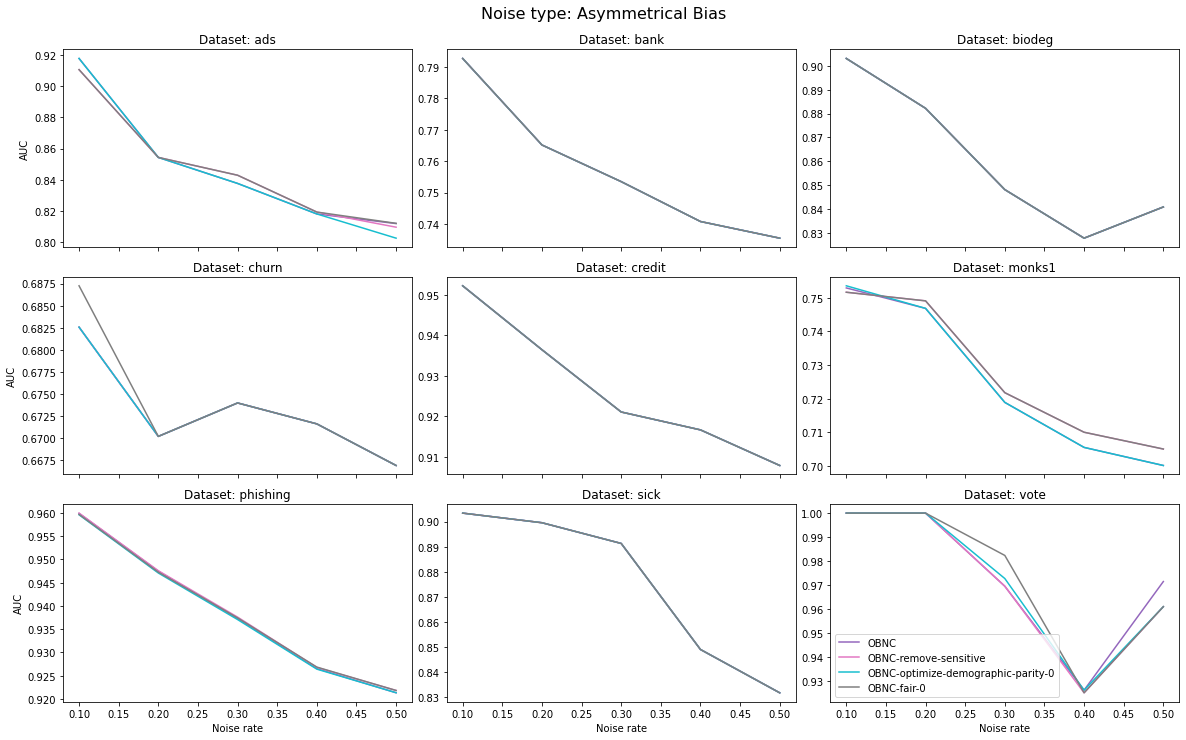

In [22]:
metric_separate_datasets('bias', 'roc_auc', 'noisy')

## Original test set

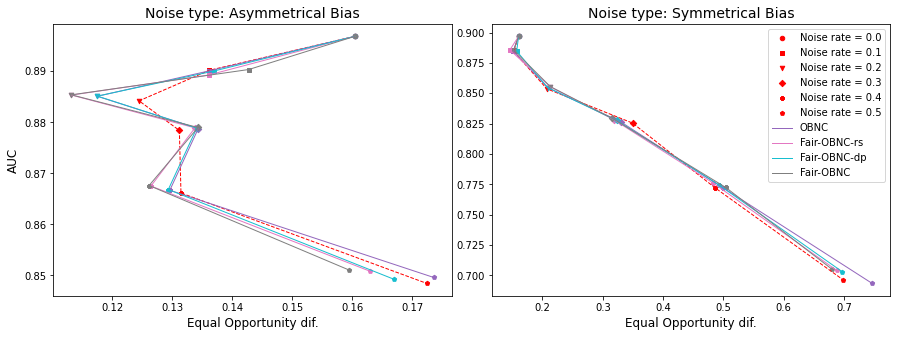

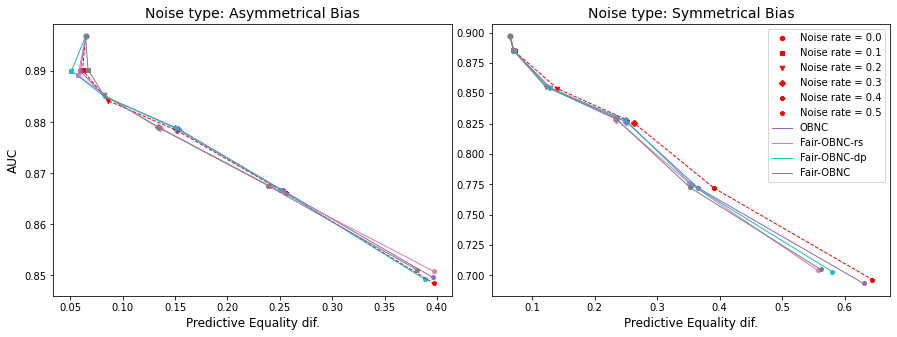

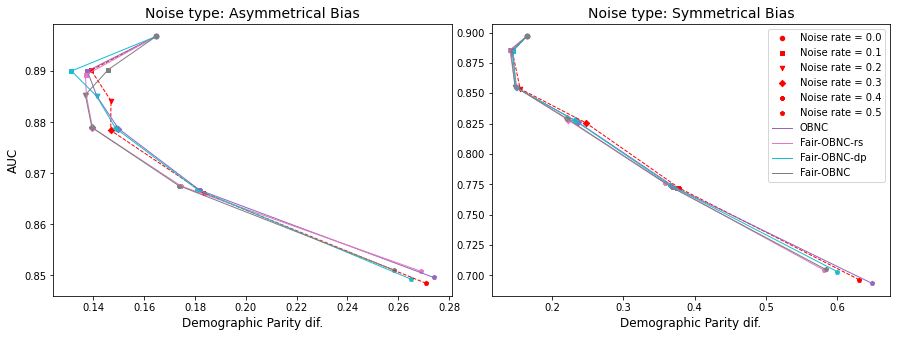

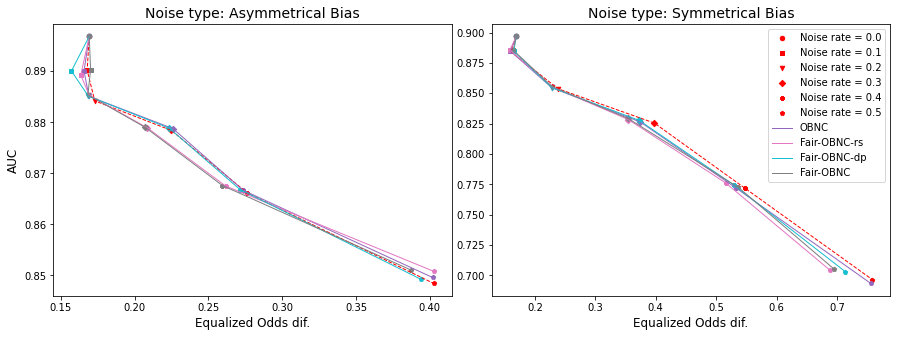

In [23]:
for metric in fair_metrics:
    trade_off_curve_all_algs('original', metric, 
                         ['OBNC', 'OBNC-remove-sensitive','OBNC-optimize-demographic-parity-0', 'OBNC-fair-0'])

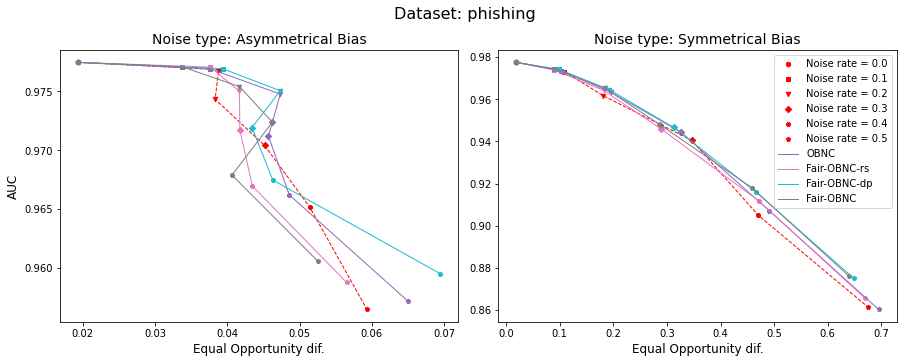

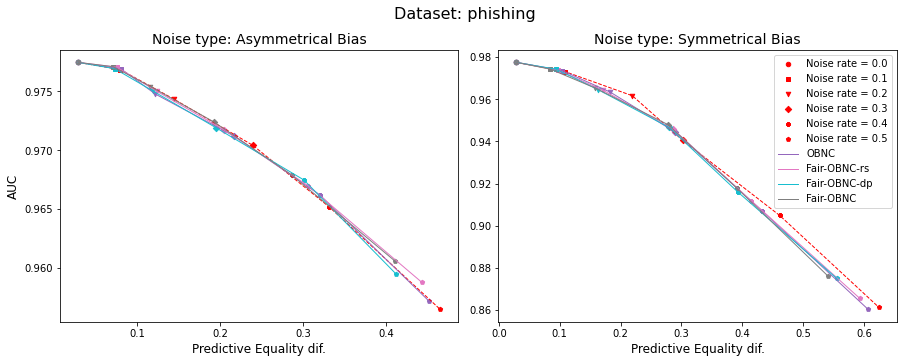

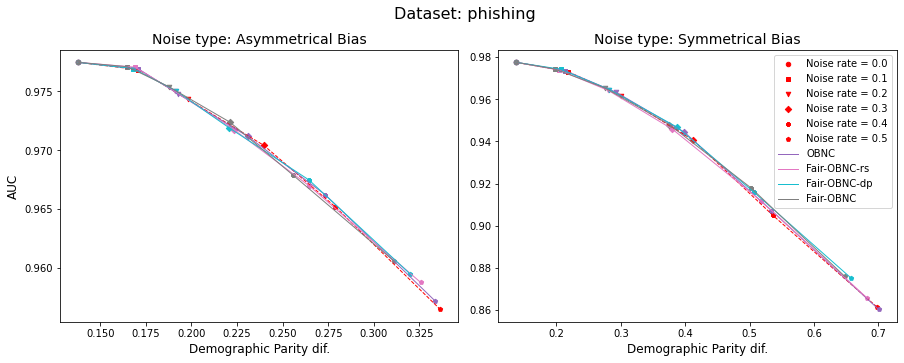

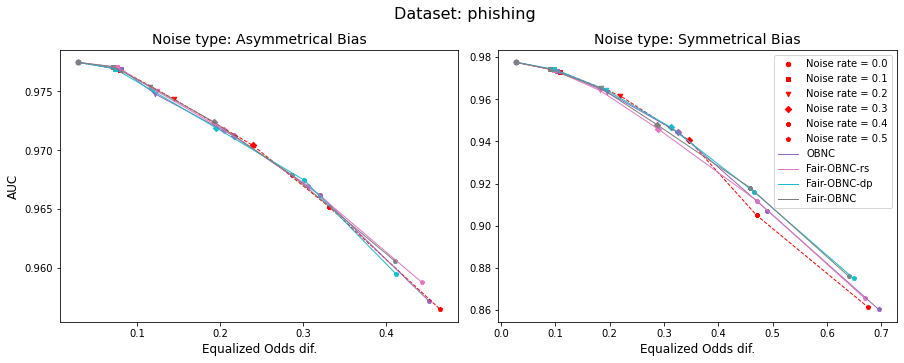

In [52]:
for metric in fair_metrics:
    trade_off_curve_all_algs_dataset('original', metric, 
                         ['OBNC', 'OBNC-remove-sensitive','OBNC-optimize-demographic-parity-0', 'OBNC-fair-0'], 'phishing')

In [24]:
# test_set = 'original'
# fair_metric = 'predictive_equality_difference_0.5'

# fig = plt.figure(figsize=(15, 5))
# axs = fig.subplots(1, 2)
# for i in range(2):
#     noise_type = noise_types[i+2]
#     ax = axs[i]
#     trade_off_curve('OBNC', noise_type, test_set, fair_metric, nr, ax, noisy=True)
#     for alg in ['OBNC-optimize-demographic-parity-0', 'OBNC-optimize-demographic-parity-0.5']:
#         trade_off_curve(alg, noise_type, test_set, fair_metric, nr, ax, labels=True)
    
#     ax.set_xlabel(metric_names[fair_metric], fontsize=12) 
#     if i == 0:
#         ax.set_ylabel('AUC', fontsize=12)
#     ax.set_title(f'Noise type: {type_names[noise_type]}', fontsize=14)
# axs[1].legend()
# plt.subplots_adjust(wspace=0.1, hspace=0.15)
# plt.savefig(f'thesis_report/fair-OBNC/noise_injection/{test_set}_test_{fair_metric}_dp.png', bbox_inches='tight')
# plt.show()

In [25]:
# test_set = 'original'
# fair_metric = 'predictive_equality_difference_0.5'

# fig = plt.figure(figsize=(15, 5))
# axs = fig.subplots(1, 2)
# for i in range(2):
#     noise_type = noise_types[i+2]
#     ax = axs[i]
#     trade_off_curve('OBNC', noise_type, test_set, fair_metric, nr, ax, noisy=True)
#     for alg in ['OBNC-fair-0', 'OBNC-fair-0.5']:
#         trade_off_curve(alg, noise_type, test_set, fair_metric, nr, ax, labels=True)
    
#     ax.set_xlabel(metric_names[fair_metric], fontsize=12) 
#     if i == 0:
#         ax.set_ylabel('AUC', fontsize=12)
#     ax.set_title(f'Noise type: {type_names[noise_type]}', fontsize=14)
# axs[1].legend()
# plt.subplots_adjust(wspace=0.1, hspace=0.15)
# plt.savefig(f'thesis_report/fair-OBNC/noise_injection/{test_set}_test_{fair_metric}_both.png', bbox_inches='tight')
# plt.show()

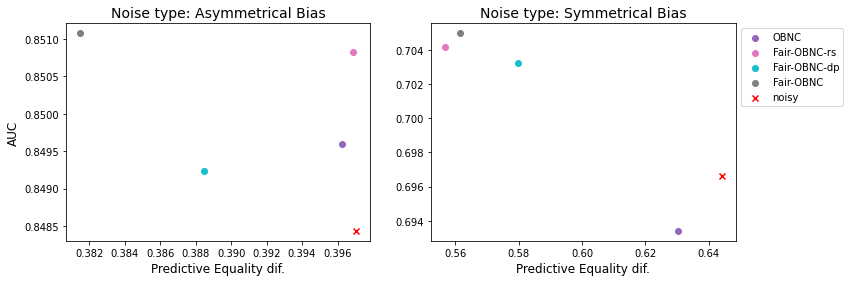

In [26]:
trade_off_all_algs('original', 'predictive_equality_difference_0.5', 
                   algorithms, 0.5)

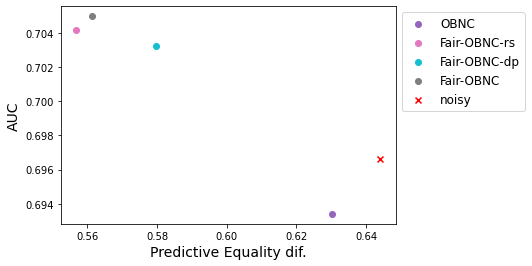

In [27]:
noise_type = 'balanced_bias'
noise_rate = 0.5
test_set = 'original'
fair_metric = 'predictive_equality_difference_0.5'

for alg in algorithms:
    fairness = []
    predictive_performance = []
    for dataset in attr.keys():
        run = runs[noise_type][f'{dataset}_{attr[dataset]}_{alg}']
        run = run.loc[(run['tags.test_set'] == test_set) & (run['tags.train_set'] == 'corrected') & (run['params.noise_rate'] == noise_rate)]
        fairness.append(run[f'metrics.{fair_metric}'].values[0])
        predictive_performance.append(run['metrics.roc_auc'].values[0])
    plt.scatter(np.mean(fairness), np.mean(predictive_performance), color=colors[alg], label=alg_names[alg])

fairness = []
predictive_performance = []
for dataset in attr.keys():
    run = runs[noise_type][f'{dataset}_{attr[dataset]}_{alg}']
    run = run.loc[(run['tags.test_set'] == test_set) & (run['tags.train_set'] == 'noisy') & (run['params.noise_rate'] == noise_rate)]
    fairness.append(run[f'metrics.{fair_metric}'].values[0])
    predictive_performance.append(run['metrics.roc_auc'].values[0])
plt.scatter(np.mean(fairness), np.mean(predictive_performance), color='red', marker='x', label='noisy')

#plt.title(f'Noise type: {type_names[noise_type]}')
plt.xlabel(metric_names[fair_metric], fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)
plt.show()

## Corrected test set

In [28]:
def show_corrected_test_performance(noise_type, metric):
    fig = plt.figure(figsize=(12, 6))
    axs = fig.subplots(2, 2, sharey=True, sharex=True)

    for i in range(4):
        row = i // 2
        col = i % 2
        alg = algorithms[i]

        results = {noise_rate: [] for noise_rate in nr}
        results_original = {noise_rate: [] for noise_rate in nr}

        for dataset in attr.keys():
            exp = f'{dataset}_{attr[dataset]}'
            run = runs[noise_type][f'{exp}_{alg}']
            run = run.loc[run['tags.test_set'] == 'corrected']
            for noise_rate in nr:
                results[noise_rate].append(run.loc[(run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'corrected')][f'metrics.{metric}'].values[0])
            
            run = runs[noise_type][f'{exp}_{alg}']
            run = run.loc[run['tags.test_set'] == 'original']
            for noise_rate in nr:
                results_original[noise_rate].append(run.loc[(run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'corrected')][f'metrics.{metric}'].values[0])
            
        axs[row, col].plot(nr, [np.mean(results_original[noise_rate]) for noise_rate in nr], label='original test set', color='black', linestyle='--', linewidth=2)
        axs[row, col].errorbar(nr, [np.mean(results[noise_rate]) for noise_rate in nr], yerr=[np.std(results[noise_rate]) for noise_rate in nr] , label=f'{alg_names[alg]} corrected test set', color=colors[alg])

        if row == 1:
            axs[row, col].set_xlabel('Noise rate', fontsize=12)
        if col == 0:
            axs[row, col].set_ylabel(metric_names[metric], fontsize=12)

        axs[row, col].legend()
        axs[row, col].set_title(f'Train set: {alg} corrected')

    plt.subplots_adjust(wspace=0.07, hspace=0.2)
    plt.suptitle(f'Noise type: {type_names[noise_type]}', fontsize=16, y=1)
    plt.savefig(f'thesis_report/fair-OBNC/noise_injection/corrected_test_{metric}_{noise_type}.png', bbox_inches='tight')
    plt.show()

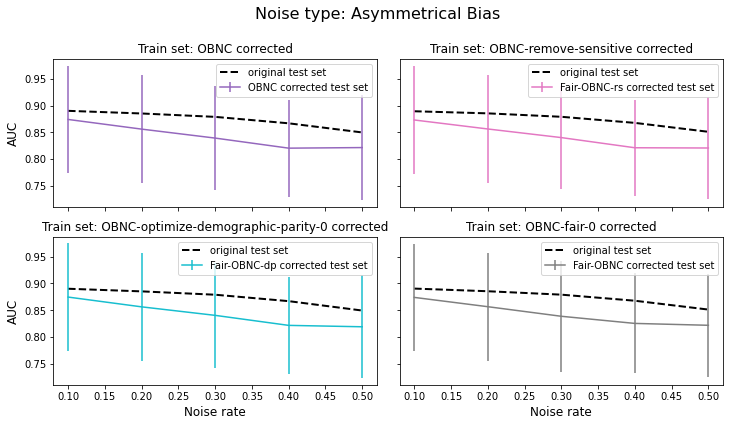

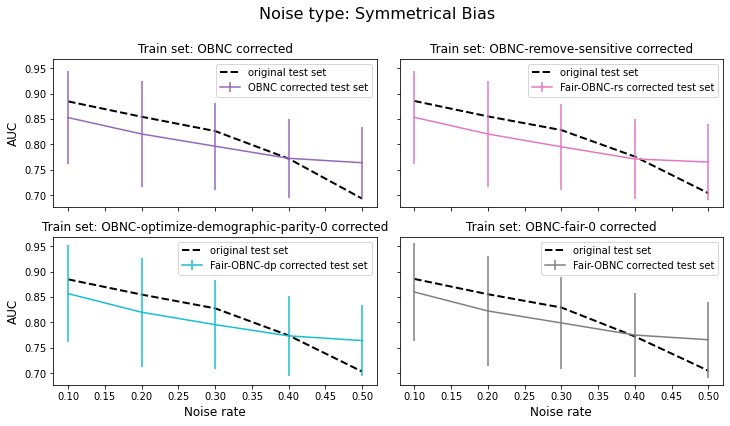

In [29]:
for noise_type in noise_types[2:]:
    show_corrected_test_performance(noise_type, 'roc_auc')

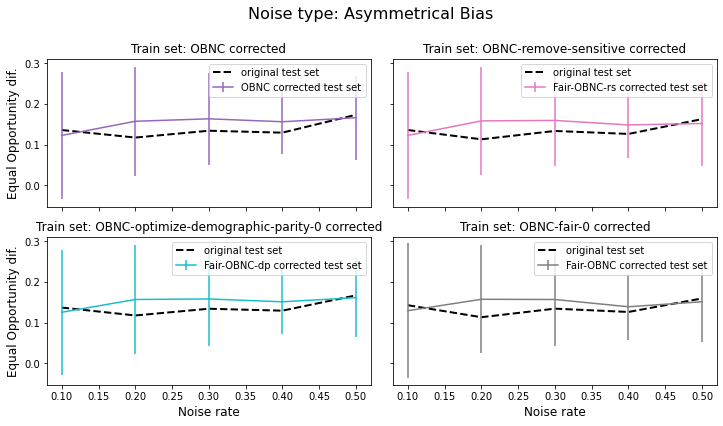

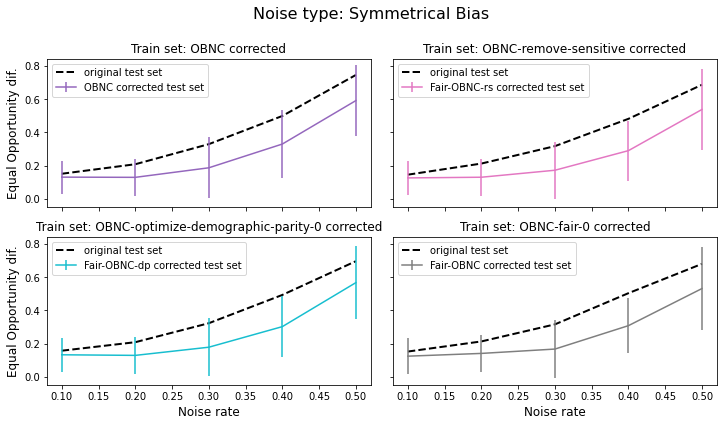

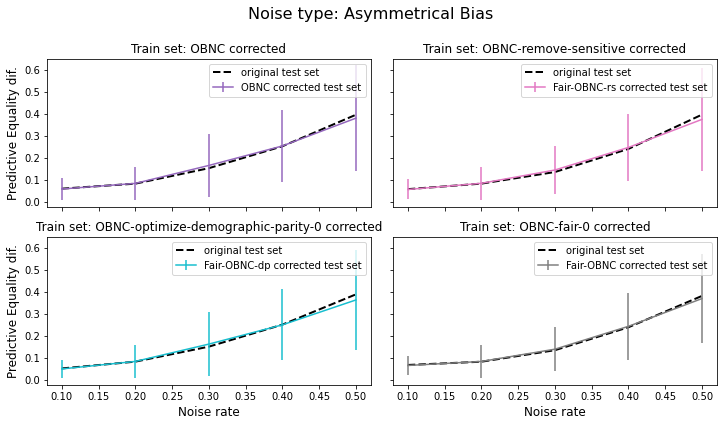

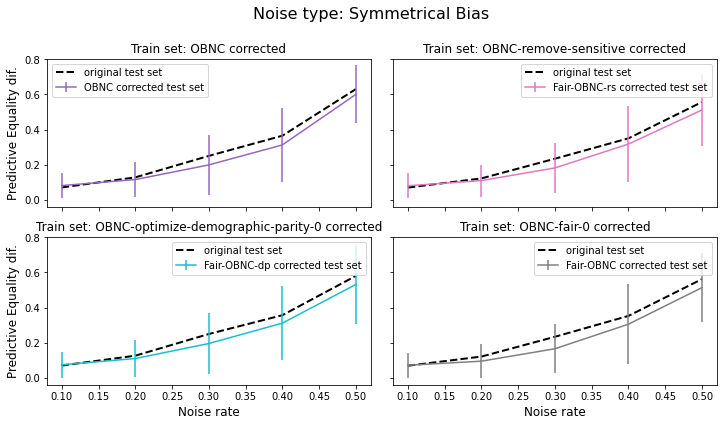

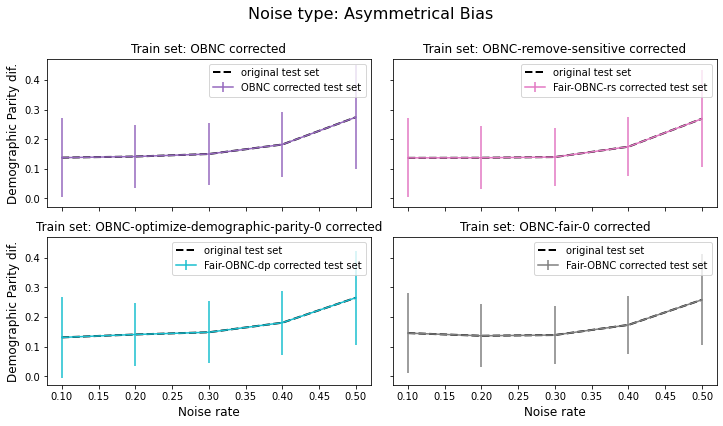

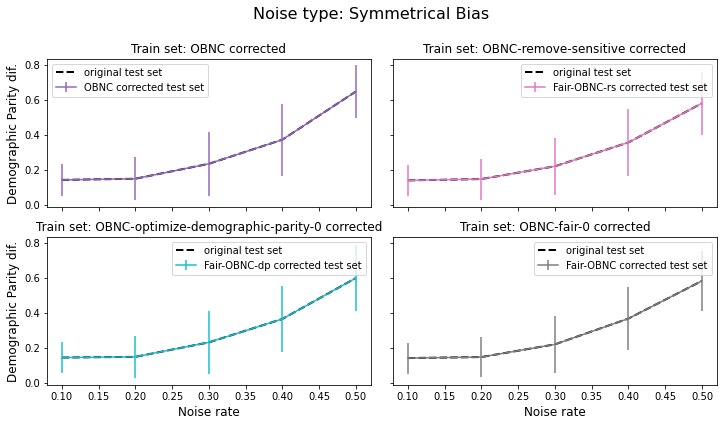

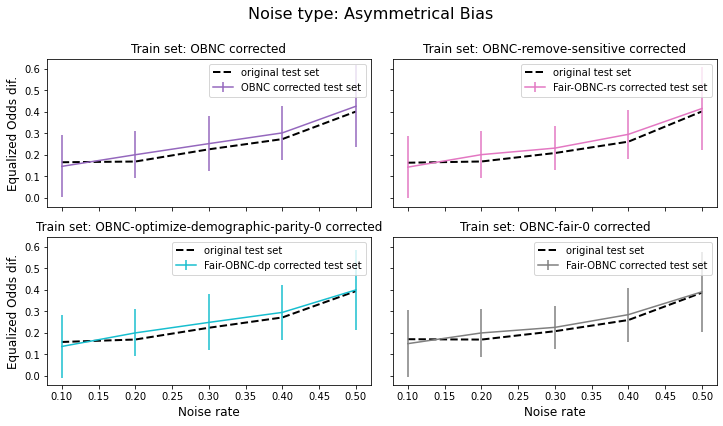

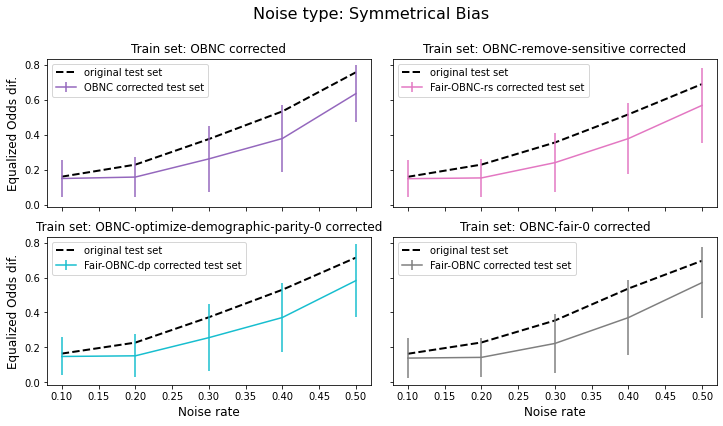

In [30]:
for fair_metric in fair_metrics:
    for noise_type in noise_types[2:]:
        show_corrected_test_performance(noise_type, fair_metric)

# Fairness benchmark experiments

## Originally biased test set

In [31]:
def trade_off(test_set, fair_metric, pred_metric):
    for alg in algorithms:
        fairness = []
        predictive = []
        for dataset in attr_fairness.keys():
            for sensitive_attr in attr_fairness[dataset]:
                run = runs['fairness'][f'{dataset}_{sensitive_attr}_{alg}']
                run = run.loc[(run['tags.train_set'] == 'corrected') & (run['tags.test_set'] == test_set)]
                if pd.notna(run[f'metrics.{fair_metric}'].values[0]):
                    fairness.append(run[f'metrics.{fair_metric}'].values[0])
                if pd.notna(run[f'metrics.{pred_metric}'].values[0]):
                    predictive.append(run[f'metrics.{pred_metric}'].values[0])
        plt.scatter(np.mean(fairness), np.mean(predictive), label=alg_names[alg], color=colors[alg])

    fairness = []
    predictive = []
    for dataset in attr_fairness.keys():
        for sensitive_attr in attr_fairness[dataset]:
            run = runs['fairness'][f'{dataset}_{sensitive_attr}_{algorithms[0]}']
            run = run.loc[(run['tags.train_set'] == 'noisy') & (run['tags.test_set'] == test_set)]
            if pd.notna(run[f'metrics.{fair_metric}'].values[0]):
                fairness.append(run[f'metrics.{fair_metric}'].values[0])
            if pd.notna(run[f'metrics.{pred_metric}'].values[0]):
                predictive.append(run[f'metrics.{pred_metric}'].values[0])
    plt.scatter(np.mean(fairness), np.mean(predictive), label='originally biased', color='red', marker='x')

    lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)
    plt.xlabel(metric_names[fair_metric], fontsize=12)
    plt.ylabel(metric_names[pred_metric], fontsize=12)
    plt.title(f'Originally biased test set' if test_set == 'noisy' else f'Corrected test set', fontsize=14)
    plt.savefig(f'thesis_report/fair-OBNC/fairness_benchmarks/{test_set}_test_{fair_metric}_{pred_metric}.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

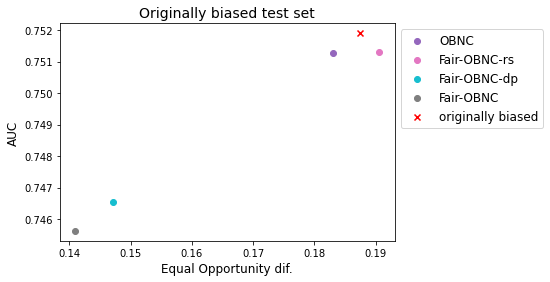

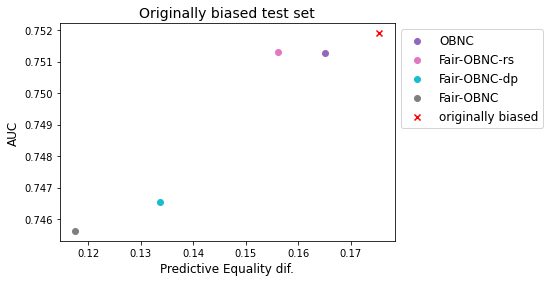

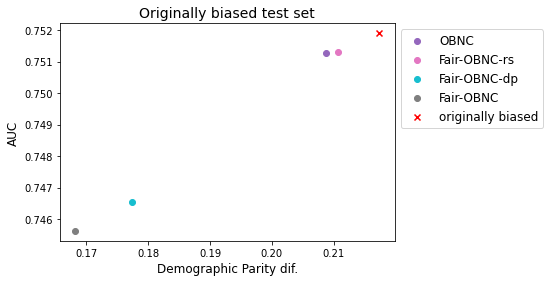

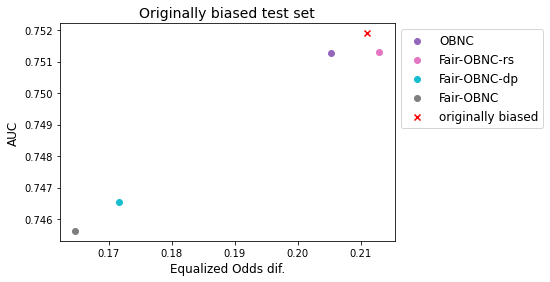

In [32]:
for fair_metric in fair_metrics:
    trade_off('noisy', fair_metric, 'roc_auc')

In [33]:
def trade_off_datasets(fair_metric, pred_metric, test_set):
    fig = plt.figure(figsize=(20, 8))
    axs = fig.subplots(2, 4)

    i = 0
    for dataset in attr_fairness.keys():
        for sensitive_attr in attr_fairness[dataset]:
            row = i // 4
            col = i % 4
            ax = axs[row, col]
            for alg in algorithms:
                run = runs['fairness'][f'{dataset}_{sensitive_attr}_{alg}']
                run = run.loc[(run['tags.train_set'] == 'corrected') & (run['tags.test_set'] == test_set)]
                ax.scatter(run[f'metrics.{fair_metric}'].values[0], run[f'metrics.{pred_metric}'].values[0], label=alg_names[alg], color=colors[alg])

            run = runs['fairness'][f'{dataset}_{sensitive_attr}_{algorithms[0]}']
            run = run.loc[(run['tags.train_set'] == 'noisy') & (run['tags.test_set'] == test_set)]
            ax.scatter(run[f'metrics.{fair_metric}'].values[0], run[f'metrics.{pred_metric}'].values[0], label='originally biased', color='red', marker='x')

            if row == 1:
                ax.set_xlabel(metric_names[fair_metric], fontsize=12)
            if col == 0:
                ax.set_ylabel(metric_names[pred_metric], fontsize=12)
            ax.set_title(f'{dataset}', fontsize=14)

            i += 1

    lgd = axs[1, 3].legend(bbox_to_anchor=(1, 1), loc='upper left')

    #plt.savefig(f'thesis_report/fair-OBNC/fairness_benchmarks/{test_set}_test_{fair_metric}_{pred_metric}.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

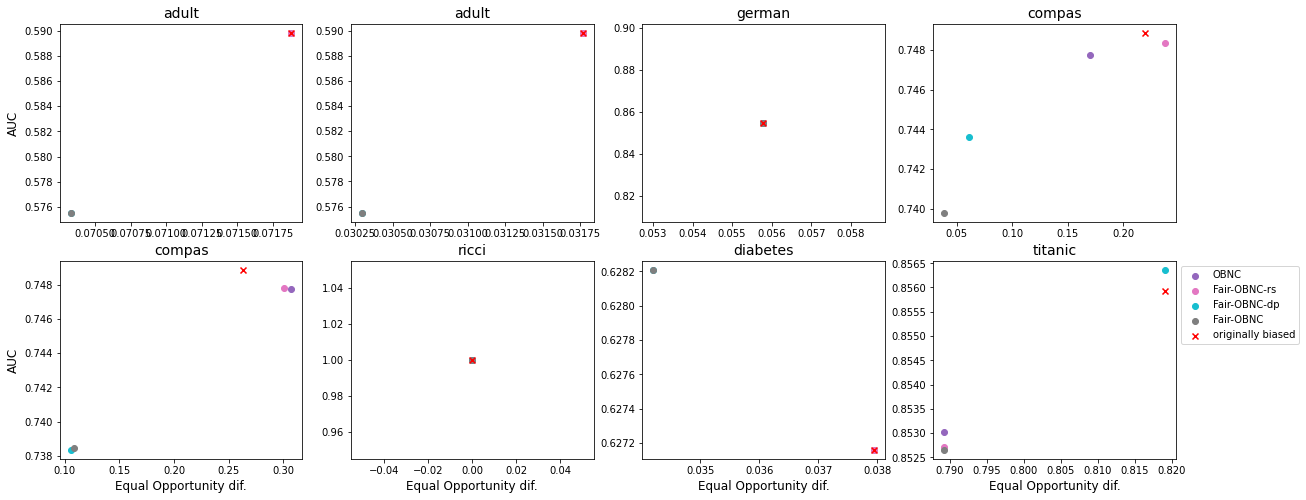

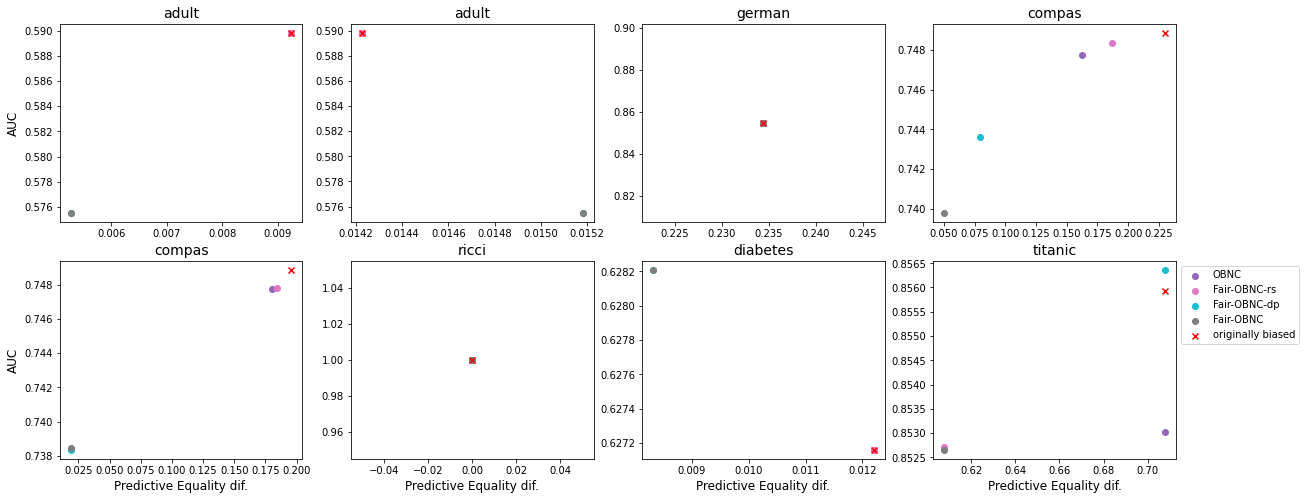

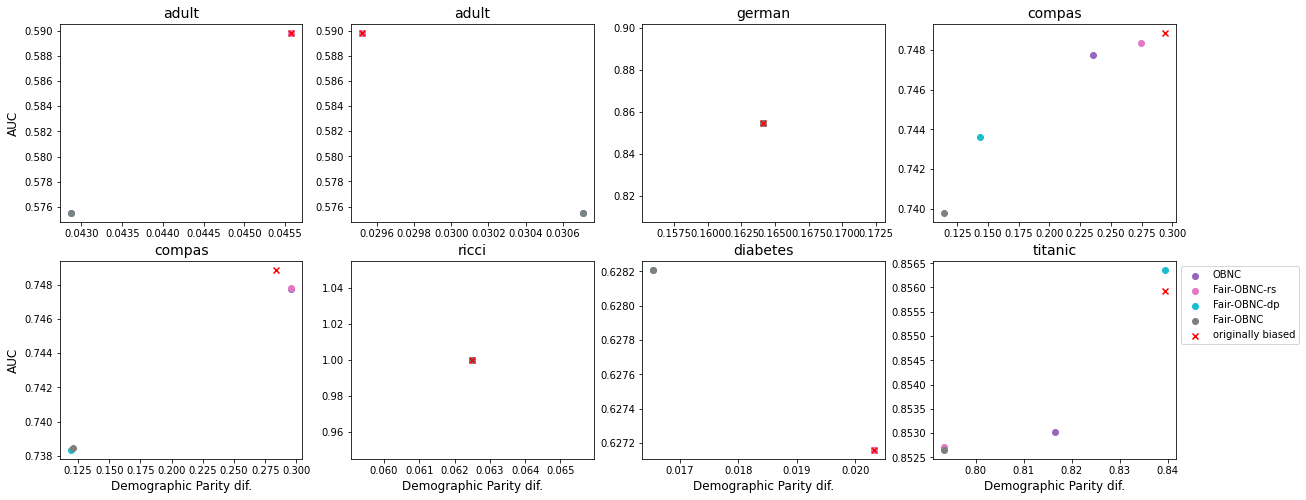

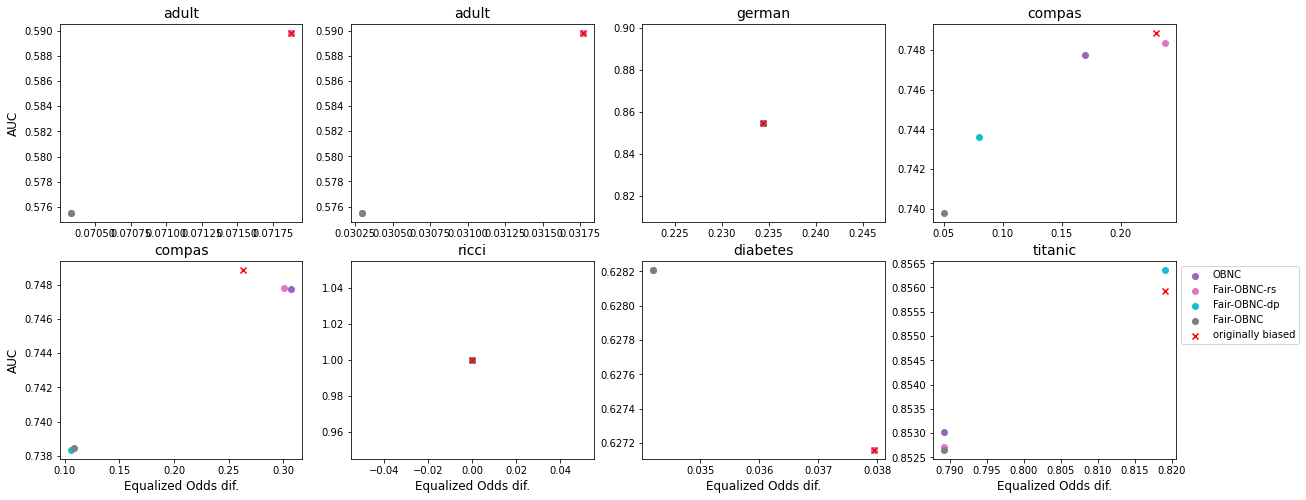

In [34]:
for fair_metric in fair_metrics:
    trade_off_datasets(fair_metric, 'roc_auc', 'noisy')

# Corrected test set

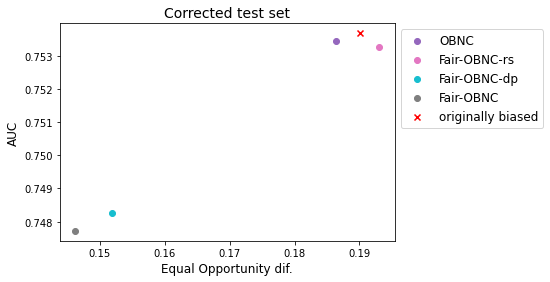

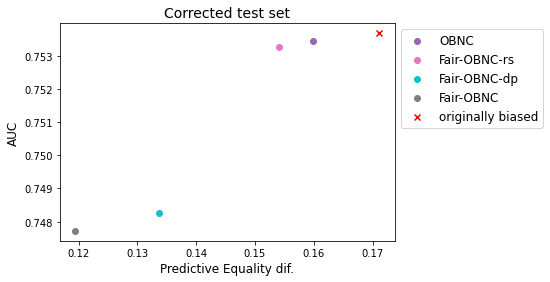

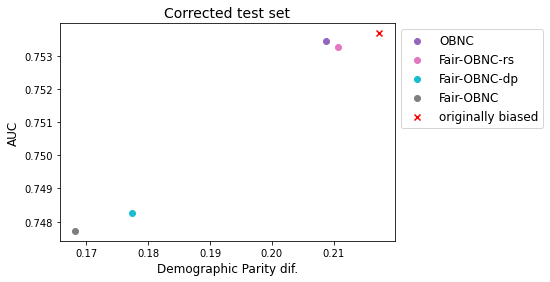

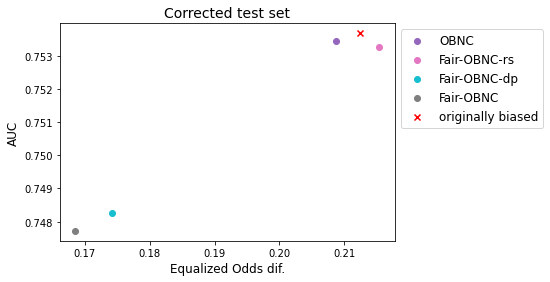

In [35]:
for fair_metric in fair_metrics:
    trade_off('corrected', fair_metric, 'roc_auc')

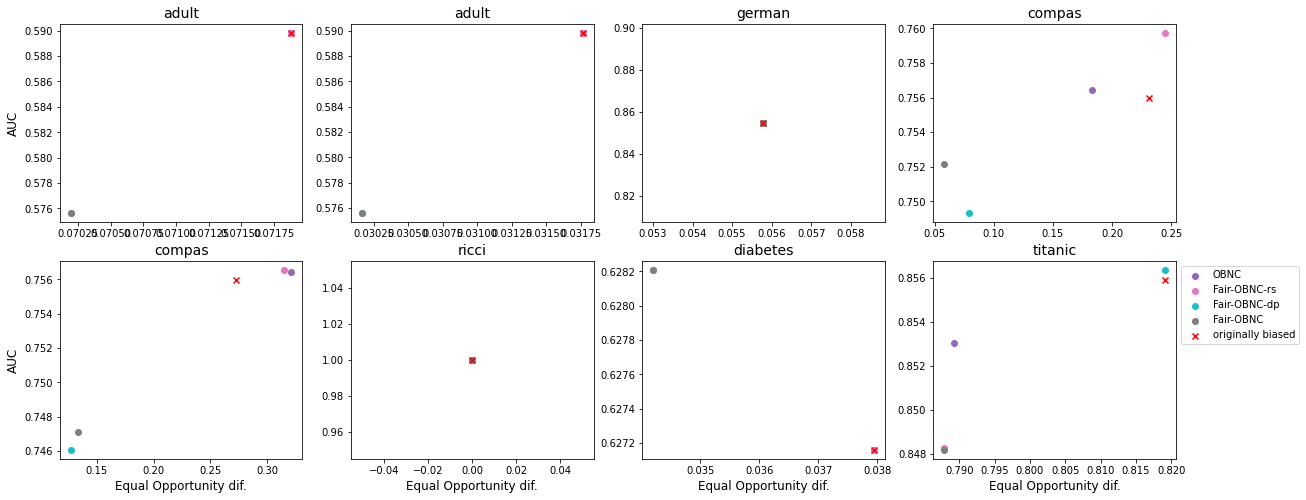

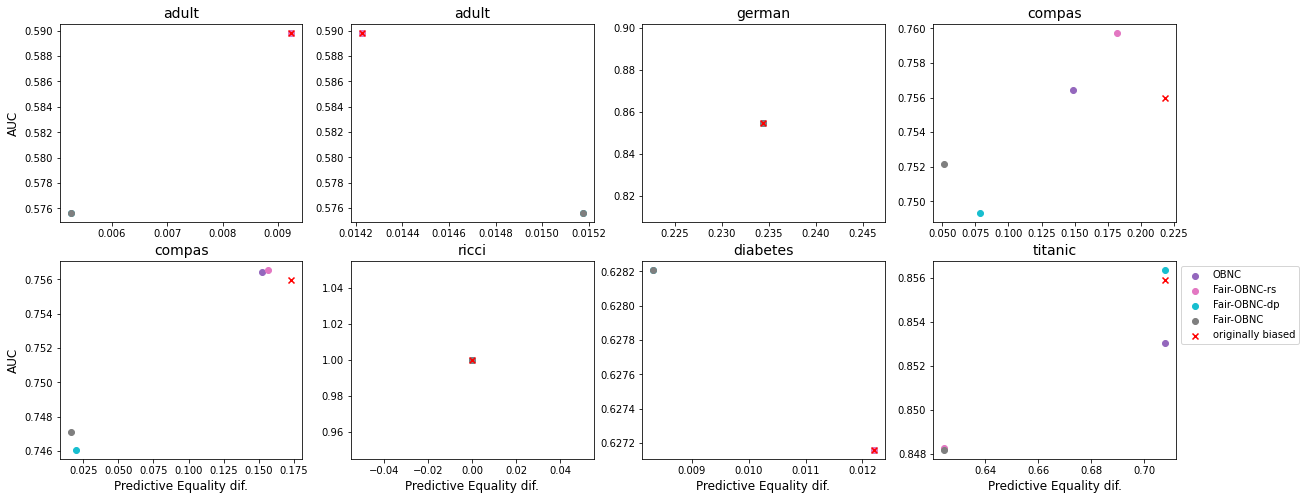

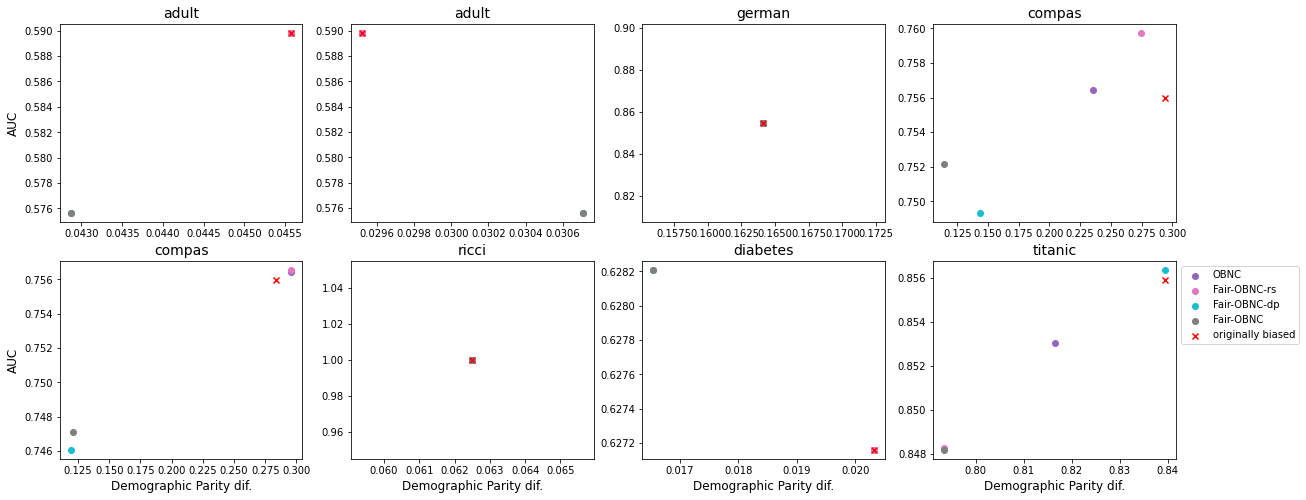

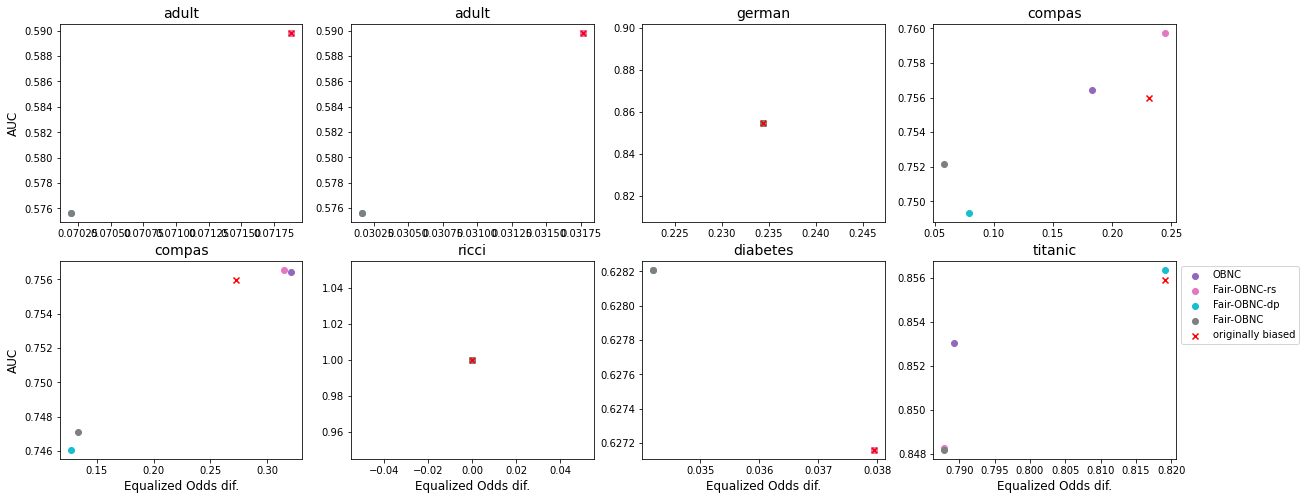

In [36]:
for fair_metric in fair_metrics:
    trade_off_datasets(fair_metric, 'roc_auc', 'corrected')